![Lyra Logo](https://images.squarespace-cdn.com/content/v1/613f1e4d6b0212660acd9923/b4bd6af5-31a4-4079-a2cb-7632b5f24f58/Horizontal_nobackground.png?format=1500w)

# 📘 Predicting Energy Consumption in Electric Vehicle (EV) Data Using Machine Learning
---

### 🚀 Business Problem
Fleet managers need to reduce energy consumption and operational costs. Predicting energy usage per trip helps optimize fleet scheduling and improve energy efficiency.

### 🎯 ML Problem Formulation
We frame this as a **supervised regression** task:  
**Target:** Energy consumption per trip (`SoC_used = soc_start - soc_stop`)  
**Features:** distance, duration, speed_max, temperature, fleet_type, etc.  
**Goal:** Build a model to predict `SoC_used`, and identify the key drivers of energy usage.

## 📊 Dataset Overview
The dataset is sourced from the **RWTH Aachen University** research repository (https://publications.rwth-aachen.de/record/979878) contains 4 datasets. I focus on the first dataset, `trip_data`, which includes the following columns:
- `trip_id`, `vehicle`, `starttime` 
- `duration` (in seconds)
- `odometer_start` (in km), `distance` (in km)
- `soc_start`, `soc_stop` (battery state of charge, in %)
- `speed_max` (in km/h), `temperature_ambient_avg` (in °C)
- `fleet_type` (Commuter, Rural Carsharing,....)

## 🛠️ Summary
1. **Data Loading and Preprocessing**
   - Combine all fleet data from multiple `.parquet` files
   - Feature engineering and handling missing data
   - Calculate energy consumption (SoC_used)

2. **Modeling**
   - Train **Random Forest** and **XGBoost** models
   - Use **GridSearchCV** and **RandomizedSearchCV** for hyperparameter tuning

3. **Evaluation**
   - Evaluate models using MAE, RMSE, and R²
   - Analyze **feature importance** to identify key drivers of energy use

4. **Conclusion and Future Outlook**
5. **Ethical Considerations & Limitations**
6. **Acknowledgements**

---

This notebook ultimately aims to provide data-driven insights to support smarter, more sustainable EV fleet operations.
> ✨ *Some sections of this notebook were supported by AI tools (notably ChatGPT by OpenAI), used to enhance clarity, structure, and exploration.*

# 🔍 Data Loading and Preprocessing Summary

We perform the following tasks:

1. **Loads all `.parquet` files** from a specified directory containing trip data for electric vehicles.
2. **Extracts the fleet type** from each filename (e.g., `Commuter_trip_data_1h.parquet` → `Commuter`).
3. **Reads each file** into a Pandas DataFrame and appends the `fleet_type` as a new column.
4. **Combines all DataFrames** into one unified dataset using `pd.concat()`.
This step sets the foundation for further **exploratory data analysis (EDA)** and modeling.

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno

# Define the folder path where the Parquet files are stored
folder_path = "d:/anter saadaoui/Projekt/Electric_Vehicle_and_Battery_Data/trip_data"

# List all files in the folder that end with '.parquet'
files = [f for f in os.listdir(folder_path) if f.endswith(".parquet")]

# Initialize an empty list to store DataFrames
df_list = []

# Loop through each file
for file in files:
    # Extract the fleet type from the filename (before the first underscore '_')
    fleet_type = file.split("_")[0]

    # Construct the full file path
    full_path = os.path.join(folder_path, file)

    # Read the Parquet file into a DataFrame
    dfs = pd.read_parquet(full_path)

    # Add a new column to indicate the fleet type
    dfs["fleet_type"] = fleet_type

    # Append the DataFrame to the list
    df_list.append(dfs)

# Concatenate all DataFrames into a single DataFrame
full_df = pd.concat(df_list, ignore_index=True)

# Display the shape of the combined dataset (rows, columns)
print(full_df.shape)

# Show the number of entries per fleet type
print(full_df["fleet_type"].value_counts())

# Display the first 2 rows of the dataset, without showing the index
print(full_df.head(2).to_string(index=False))

(27315, 11)
fleet_type
GeriatricCare      15956
UrbanCarsharing     4653
RuralCarsharing     4089
Commuter            2617
Name: count, dtype: int64
 trip_id vehicle             starttime  duration_seconds  odometer_start  distance  soc_start  soc_stop  speed_max  temperature_ambient_avg fleet_type
     1.0   iOn-2 2014-08-14 14:38:13.0             743.0          8703.0       0.0       77.5      81.5        0.0                21.796667   Commuter
     2.0   iOn-2 2014-08-14 18:37:22.0             649.0          8703.0       9.0       99.5      93.0       93.0                17.348667   Commuter


## 🚗 Fleet Type Distribution Analysis (as % of Total Trips)

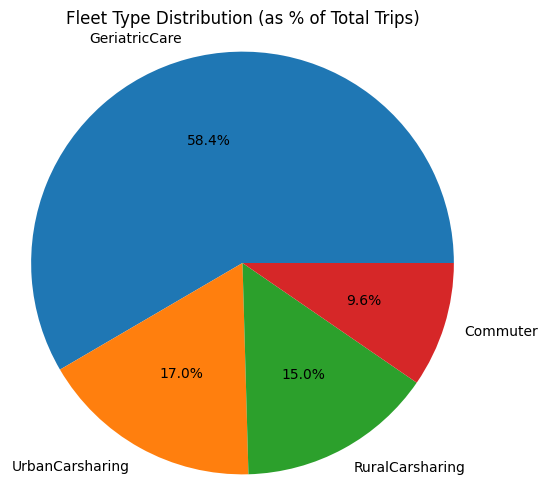

In [2]:
plt.figure(figsize=(6, 6))
plt.pie(full_df['fleet_type'].value_counts(), labels=full_df['fleet_type'].value_counts().index, autopct='%1.1f%%')
plt.title('Fleet Type Distribution (as % of Total Trips)')
plt.axis('equal')  # Ensures that pie is drawn as a circle.
plt.show()

# 🔍 Interpretation

- As we see in this pie **Geriatric Care cars** dominates the trip volume, accounting for **over half (58.4%)** of all trips. This suggests a high demand for elderly transport services, because it linked to healthcare or assisted mobility.
- **Urban Carsharing** and **Rural Carsharing** are forming together roughly **one-third** of the dataset. **Commuter** has the **smallest share (9.6%)**.

# ⚠️ Challenge: Class Imbalance

The dataset is clearly **imbalanced**, with **Geriatric Care** cars heavily overrepresented.

In [3]:
full_df.describe()

,trip_id,duration_seconds,odometer_start,distance,soc_start,soc_stop,speed_max,temperature_ambient_avg
count,27315.000000,2.731500e+04,26151.000000,25726.000000,27315.000000,27315.000000,25516.000000,26068.000000
mean,6206.810837,3.840672e+03,12632.358992,6.360763,79.333429,73.011605,60.087435,10.732822
std,8508.748606,5.162768e+04,6585.315276,11.774408,17.298066,18.547435,24.949421,6.547781
min,1.000000,0.000000e+00,200.000000,0.000000,0.000000,0.000000,0.000000,-8.320000
25%,579.000000,2.130000e+02,7273.500000,1.000000,69.600000,62.300000,50.000000,5.875000
50%,1844.000000,4.200000e+02,11897.000000,3.000000,83.000000,76.500000,61.000000,10.333333
75%,8457.500000,1.095000e+03,17098.500000,5.000000,93.700000,87.700000,72.000000,14.750000
max,37940.000000,7.344269e+06,38037.000000,114.000000,100.000000,100.000000,163.000000,53.500000


## 📊 Descriptive Statistics of Trip Data

- According to the describtion above, we can easly observe that there is no outliers in all the columns except the **duration_seconds**. the max of **duration_seconds** is 7344269 S which is a bit more then **85 days**. In this case we suggest that is incorrectly entred we check their number and we drop all duration more then **8 hours** (Business hours).

In [4]:
# Filter and count
count = (full_df['duration_seconds'] >= 3600 * 8).sum()

print(f"Number of rows where duration_seconds > 8 hours: {count}")

Number of rows where duration_seconds > 8 hours: 362


In [5]:
# Drop all trips longer than 8 hours (28,800 seconds)
full_df = full_df[full_df['duration_seconds'] < 28800].copy()

# 🧩 Missing Data Analysis

We check for **missing values** in each column of the dataset. This gives us a quick overview of **which features may need cleaning or imputation** before modeling.

In [6]:
# Count the number of missing (NaN) values in each column and sort them in descending order
full_df.isnull().sum().sort_values(ascending=False)

speed_max                  1774
distance                   1556
temperature_ambient_avg    1222
odometer_start             1139
starttime                     0
trip_id                       0
vehicle                       0
soc_start                     0
duration_seconds              0
soc_stop                      0
fleet_type                    0
dtype: int64

## 🕳️ Missing Value Analysis
Before handling them, we want to **visualize distributions** and **check correlations** to ensure logical filling or droping.

# 🧱 Missing Data Visualization
This step is essential to decide:
- Whether to **drop**, **impute**, or **investigate** further into the cause of the missing data.


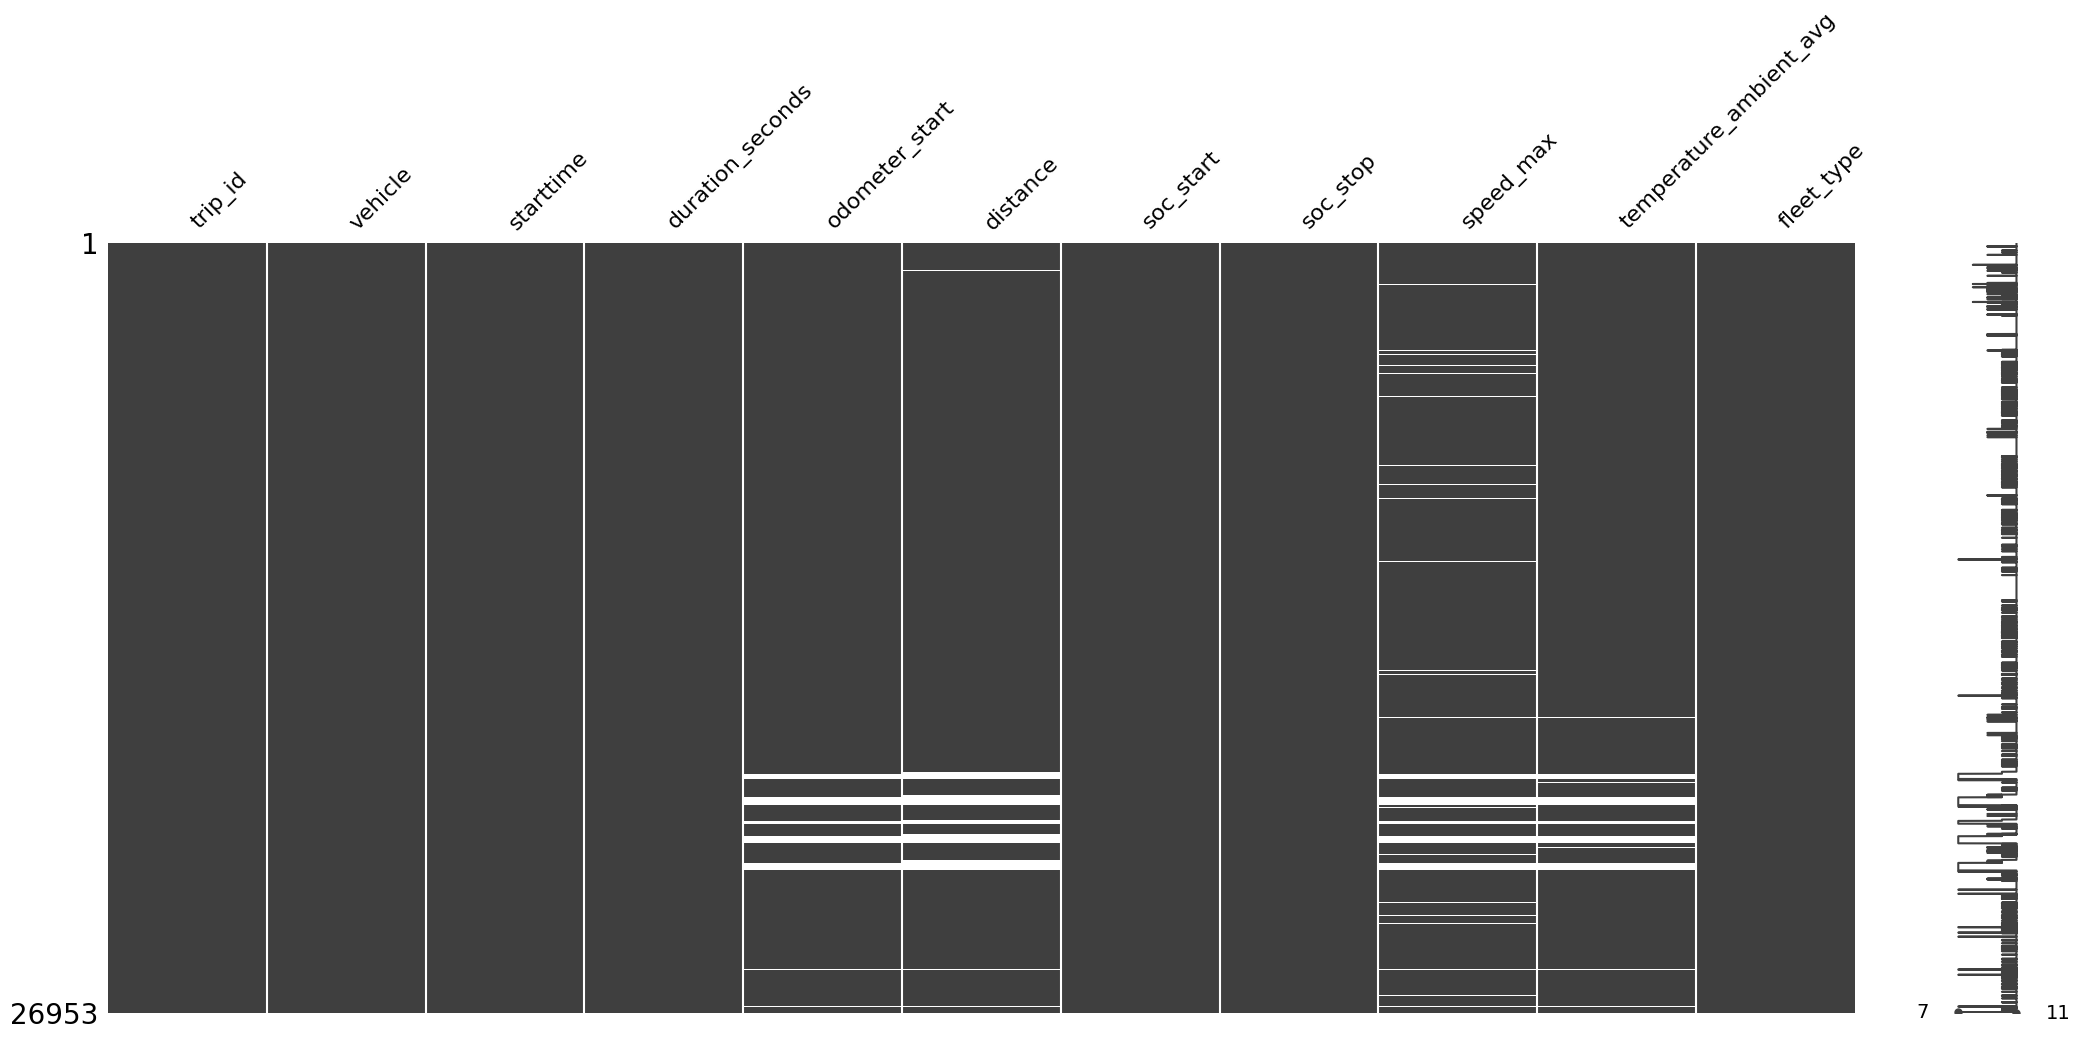

In [7]:
import missingno as msno
import matplotlib.pyplot as plt

# white lines indicate missing values
msno.matrix(full_df)

# Display the plot
plt.show()

## 🧯 Visual Missing Data Audit
  - `trip_id`, `vehicle`, `starttime`, `duration_seconds`, `soc_start`, `soc_stop`, `fleet_type` are are fully populated.
  
but:
  - `odometer_start`: we think it is due to a stationary trips.
  - `distance`: distance is derived from odometer, so the missing data due to the missing values of `odometer_start`.
  - `speed_max`: possibly for stationary trips (just started the car without moving).
  - `temperature_ambient_avg`: could be due to sensor or environmental reading errors.

# 🔥 Missing Data Correlation Heatmap
We use this to:
- Decide if some features can be **imputed based on others**,
- Detect hidden dependencies or **data collection patterns**.

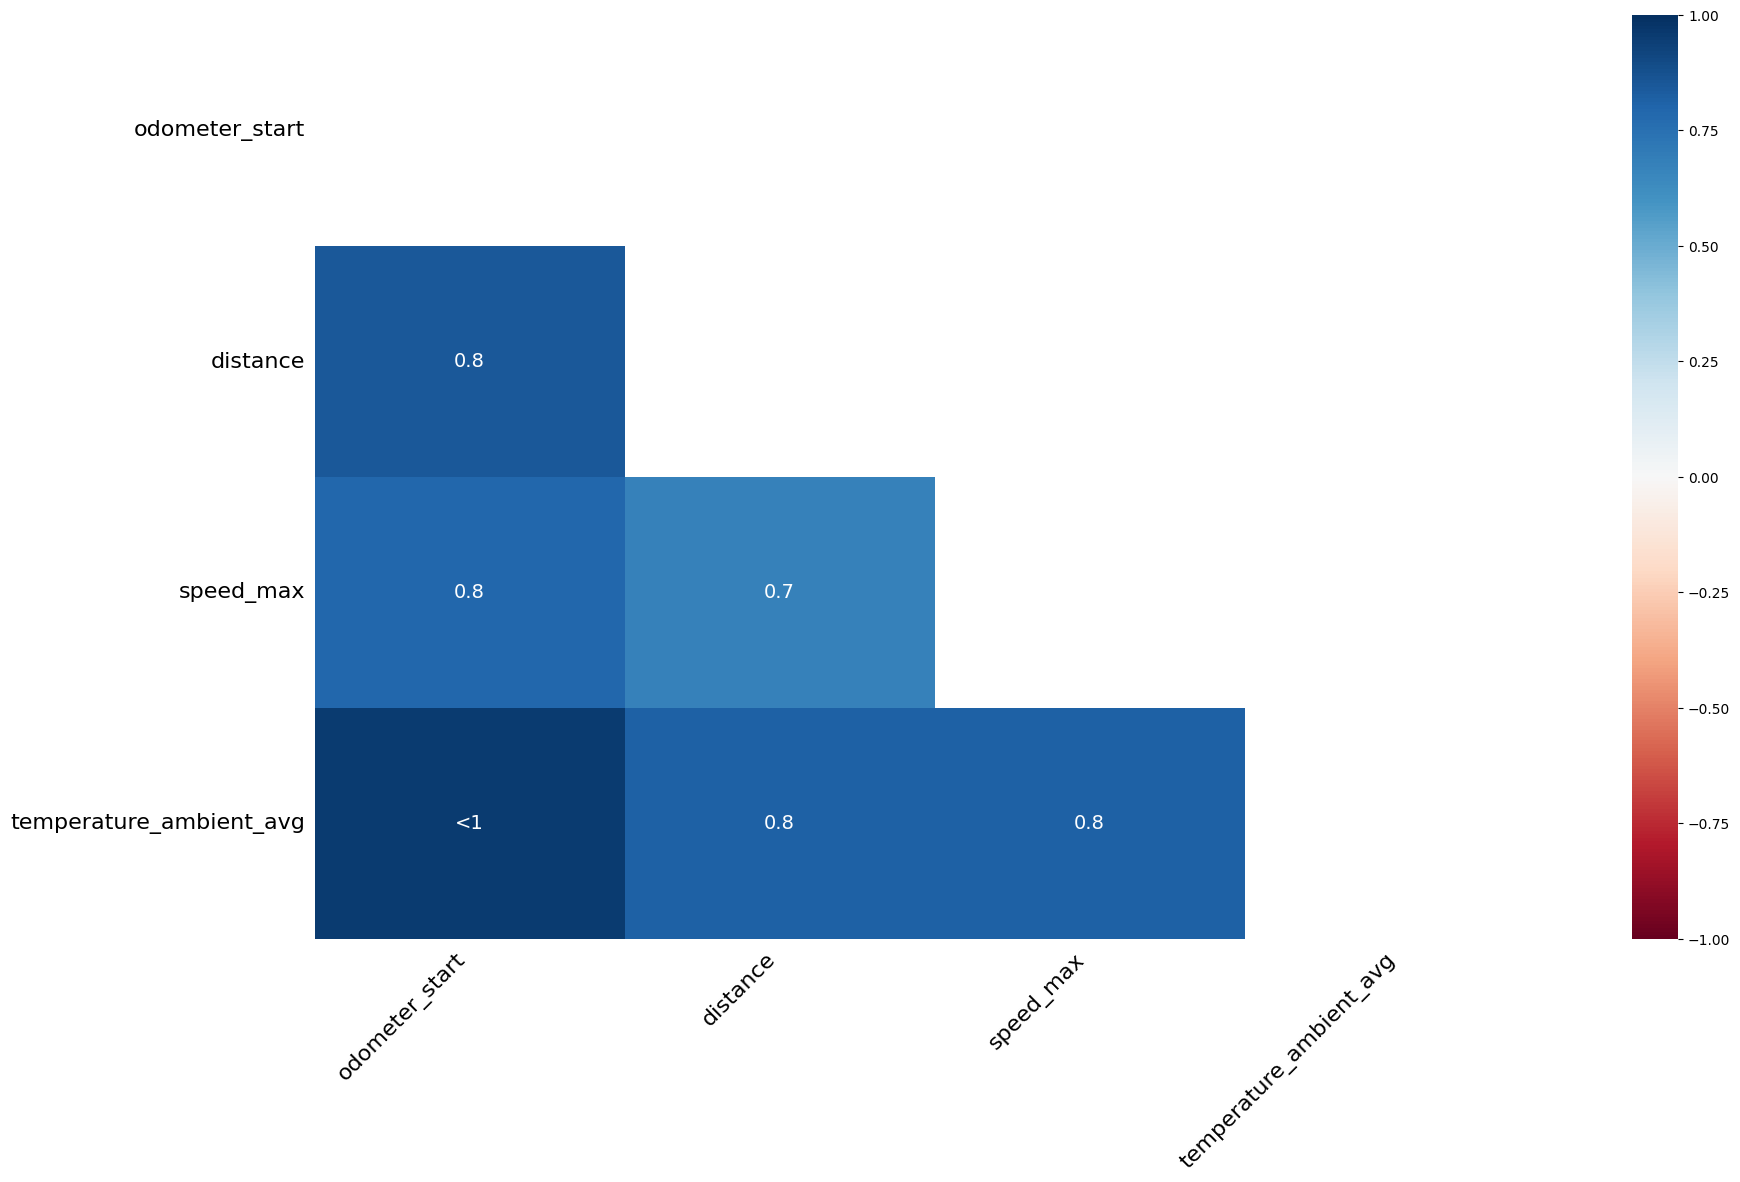

In [8]:
# Visualize the correlation of missing values between columns
msno.heatmap(full_df)

# Show the heatmap
plt.show()

## 🧠 Interpretations:
According to the heatmap the **distance** could potentially be predicted from **odometer_start**. **temperature_ambient_avg** seems to be correlate with other variables like **speed_max** and **distance**. Strong correlations between variables that should be independent (**temperature_ambient_avg** and **speed_max** or **distance**) indicate a collection of long trips might occur mostly during daytime.
# 🚦 Actionable Steps:
#### 🔍 Handling Missing Values
In this step, we decided to :

✅ Dropping rows with missing **distance** or **odometer_start**: They are key variables for trip-level analysis.

✅ Median or mean imputation for **speed_max** and **temperature_ambient_avg**: This approach helps to preserve signal over noise. We plot them to see the distribution and decide if we use median or mean imputation.

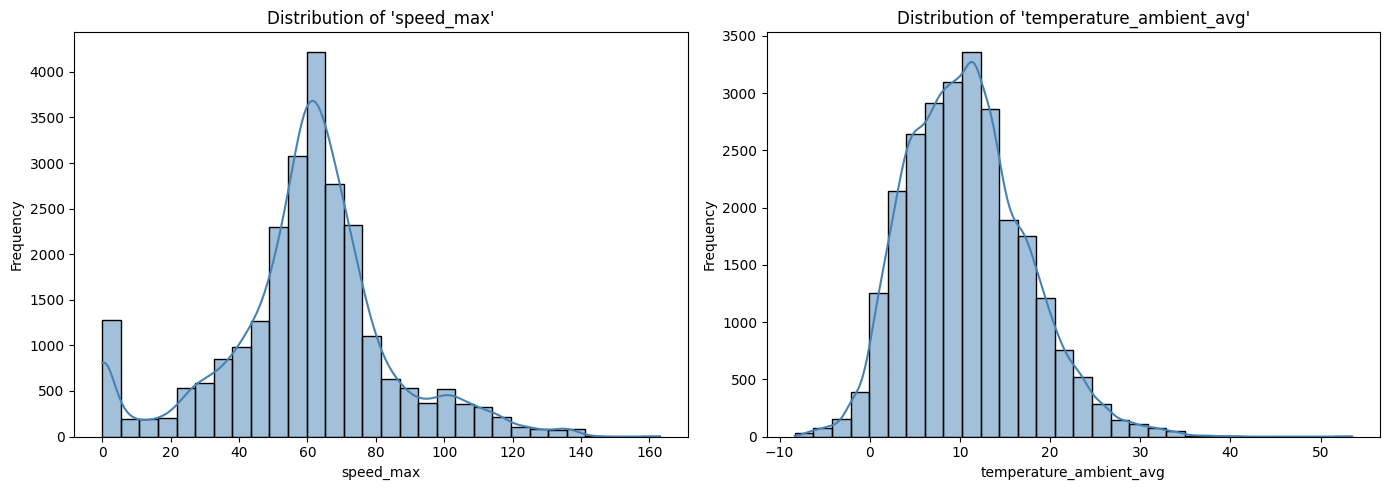

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
cols = ['speed_max', 'temperature_ambient_avg']

plt.figure(figsize=(14, 5))
for i, col in enumerate(cols):
    plt.subplot(1, 2, i+1)
    sns.histplot(full_df[col], kde=True, bins=30, color='steelblue')
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

As we see in the plot above the distribution of **speed_max** is clearly skewed to the right with a suspicious spike at zero, so using the median is the safest choice to avoid distortion. **Temperature_ambient_avg** shows a fairly normal shape with only slight skewness, making the mean a reasonable option for imputation but to get more robustness we use also the median imputation.

In [10]:
# Drop rows missing key trip metrics
df = full_df.dropna(subset=['distance', 'odometer_start']).copy()

# Median imputation for other features
for col in ['speed_max', 'temperature_ambient_avg']:
    df[col] = df[col].fillna(df[col].median())

# 📏 Average Trip Distance per Fleet

This insight can guide us on **Maintenance predictions** Or even **fleet optimization strategies**.

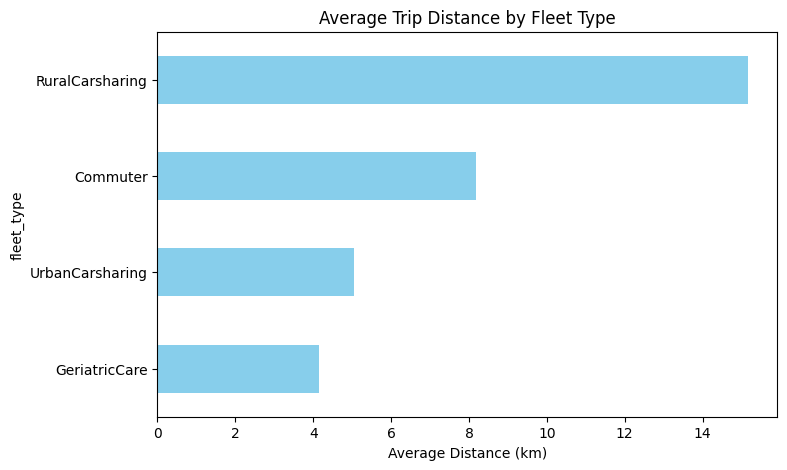

In [11]:
# Compute the average distance per fleet type and sort by value
fleet_distance = df.groupby('fleet_type')['distance'].mean().sort_values()

# Horizontal bar plot of average distance per fleet
plt.figure(figsize=(8, 5))
fleet_distance.plot(kind='barh', color='skyblue')
plt.xlabel("Average Distance (km)")
plt.title("Average Trip Distance by Fleet Type")
plt.show()


##### 👍 This chart indicate that **Rural carsharing** has the most average distance (km) and that's normal because the distancies in rural areas longer then in cities.

# ⚡ SoC Consumption by Fleet

This visualization explores **energy efficiency** per Fleet type by calculating:

- `SoC_used = soc_start - soc_stop`

In [12]:
# Calculate SoC used during each trip
df['soc_used'] = df['soc_start'] - df['soc_stop']

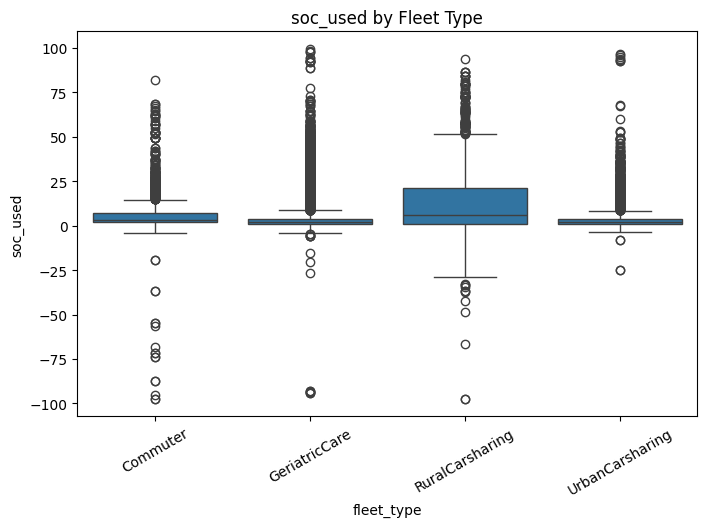

In [13]:
# Boxplot to compare maximum speed reached per fleet type
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='fleet_type', y='soc_used')
plt.title("soc_used by Fleet Type")
plt.ylabel("soc_used")
plt.xticks(rotation=30)
plt.show()

#### 📦 This Boxplot shows: The **distribution of energy consumption** (SoC_used) for each fleet type to identify which vehicles are more or less efficient. In our case **Rural Carsharing** Vehicles with higher median consumption might be overworked, undermaintained, or simply less efficient by design. But we think it is normally overworked as we see before on the average distance by fleet type.

# 🌡️ Ambient Temperature vs SoC Consumption

This scatter plot explores how **ambient temperature** affects the **energy consumption (SoC_used)** of different fleet types.

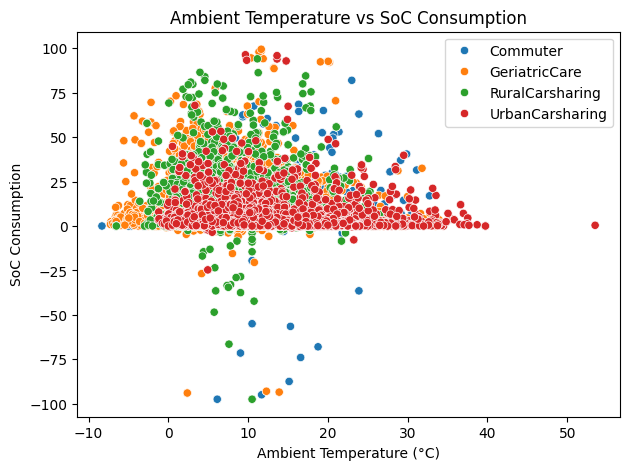

In [14]:
# Scatter plot showing relationship between ambient temperature and SoC consumption
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='temperature_ambient_avg', y='soc_used', hue='fleet_type')
plt.title("Ambient Temperature vs SoC Consumption")
plt.xlabel("Ambient Temperature (°C)")
plt.ylabel("SoC Consumption")
plt.legend()
plt.show()


### Observations:
Each dot represents a trip, colored by fleet type. We can observe that **Urban carsharing** has mostly a high temperature and it's clear in cities is mostly hot. We see that cold temperatures **increase consumption** more then hot temperature.

# 🏎️ Maximum Speed by Fleet Type

This boxplot visualizes the **distribution of maximum speeds** recorded during trips for each fleet type.

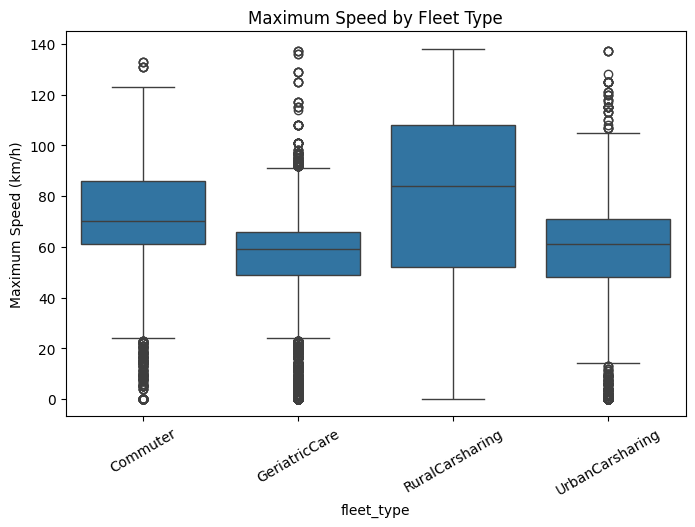

In [15]:
# Boxplot to compare maximum speed reached per fleet type
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='fleet_type', y='speed_max')
plt.title("Maximum Speed by Fleet Type")
plt.ylabel("Maximum Speed (km/h)")
plt.xticks(rotation=30)
plt.show()

### Why it matters:
- Highlights **driving behavior** differences. On our dataset, **Rural carsharing** has the highest speed and **urban** and **Geriatic care** fleets have lower speeds. So the driving in rural area is more aggressive.

# ⏰ Trip Distribution by Time of Day

On this step we categorize each trip into **custom time-of-day segments**:

- 🕔 05:00–10:59 → Morning  
- 🕛 11:00–14:59 → Midday  
- 🌇 15:00–19:59 → Evening  
- 🌙 20:00–04:59 → Night 

In [16]:
# Convert start time column to datetime format
df['starttime'] = pd.to_datetime(df['starttime'])

# Extract the hour from the start time
df['start_hour'] = df['starttime'].dt.hour

# Custom function to categorize hour into time-of-day segments
def categorize_time_of_day(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new time-of-day column
df['time_of_day'] = df['start_hour'].apply(categorize_time_of_day)

# Count the number of trips in each time-of-day category
df['time_of_day'].value_counts()

time_of_day
Morning    9482
Evening    6440
Midday     5504
Night      3971
Name: count, dtype: int64

In [17]:
# Count the number of trips in each time-of-day category
time_of_day_counts = df['time_of_day'].value_counts().reset_index()
time_of_day_counts.columns = ['time_of_day', 'trip_count']

# Sort the categories manually to keep a logical order
category_order = ['Morning', 'Midday', 'Evening', 'Night']
time_of_day_counts['time_of_day'] = pd.Categorical(
    time_of_day_counts['time_of_day'], categories=category_order, ordered=True
)
time_of_day_counts = time_of_day_counts.sort_values('time_of_day')

# Create the bar plot using Plotly Express
fig = px.bar(
    time_of_day_counts,
    x='time_of_day',
    y='trip_count',
    text='trip_count',
    color='time_of_day',
    title='🕒 Number of Trips by Time of Day',
    labels={'time_of_day': 'Time of Day', 'trip_count': 'Number of Trips'},
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()

By grouping trips this way, we can see that many trips were made during the day more then the other day period but no special or abnormal observations in this distribution.

# ⏳ Trip Duration Categorization

This step categorizes trips into **duration types** based on the number of minutes:

- **Short**: Trips under 5 minutes  
- **Medium**: Trips between 5 and 15 minutes  
- **Long**: Trips over 15 minutes

In [18]:
# Convert duration from seconds to minutes
df['duration_min'] = df['duration_seconds'] / 60

# Function to categorize trip duration based on minutes
def duration_category(mins):
    if mins < 5:
        return 'Short'
    elif mins < 15:
        return 'Medium'
    else:
        return 'Long'

# create a new column for trip duration category
df['duration_type'] = df['duration_min'].apply(duration_category)

# check the new columns
df[['duration_seconds', 'duration_min', 'duration_type']].head()

,duration_seconds,duration_min,duration_type
0,743.0,12.383333,Medium
1,649.0,10.816667,Medium
2,689.0,11.483333,Medium
3,526.0,8.766667,Medium
4,555.0,9.250000,Medium


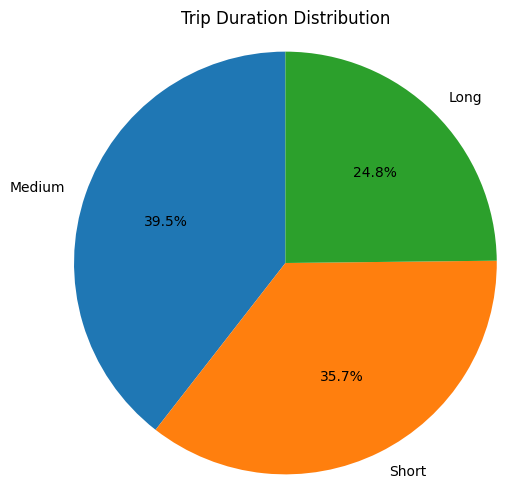

In [19]:
# Count trips by duration type
duration_counts = df['duration_type'].value_counts()

# Labels and sizes
labels = duration_counts.index
sizes = duration_counts.values

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio makes it a perfect circle
plt.axis('equal')
plt.title('Trip Duration Distribution')

plt.show()

- Helps us to **segment trips** based on their duration. As we observe in the pie chart is a bit equilibrated between the three duration distribution.

# ⚡ Energy Regeneration Rate

As we see before the **final SoC** (`soc_stop`) can be greater than the **initial SoC** (`soc_start`), this analysis checks for **energy regeneration** during trips :

- If `soc_stop > soc_start`, it indicates that the vehicle has recovered energy during braking or deceleration (regenerative braking).
- The **energy regeneration rate** is simply the **percentage of trips** where this happens.

In [20]:
# Calculate energy regeneration for trips where the final SoC is greater than the initial SoC
df['energy_regen'] = (df['soc_stop'] > df['soc_start']).astype(int)

# Calculate the rate of trips with energy regeneration (average of the binary column)
regen_rate = df['energy_regen'].mean()
print(f"Rate of trips with energy regeneration: {regen_rate:.2%}")

Rate of trips with energy regeneration: 0.88%


### Insights:
- the average rate of trips with energy regeneration is very low suggest issues with regenerative braking and driving patterns that don’t involve much regenerative braking.

# ♻️ Energy Regeneration Rate by Fleet Type

This bar chart shows the **rate of trips with energy regeneration** for each **fleet type**:

- It represents the **proportion of trips** where the final SoC is higher than the initial SoC, indicating energy recovery via regenerative braking.

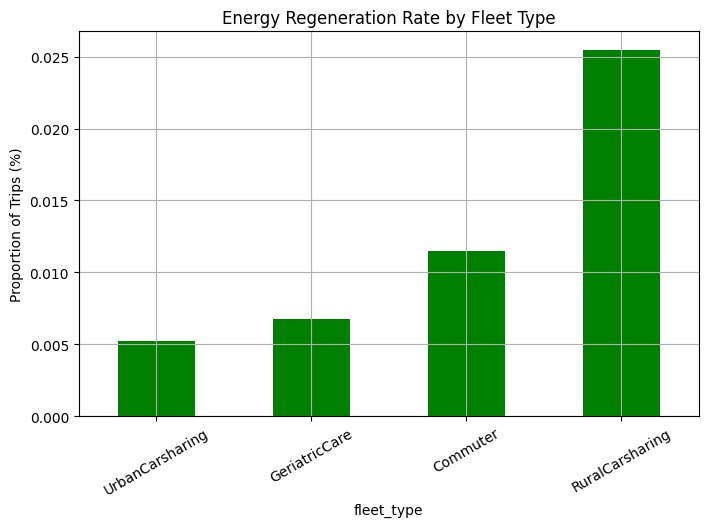

In [21]:
# Calculate the rate of energy regeneration per fleet type
regen_by_fleet = df.groupby('fleet_type')['energy_regen'].mean().sort_values()

# Plot the regeneration rate by fleet type using a bar chart
plt.figure(figsize=(8, 5))
regen_by_fleet.plot(kind='bar', color='green')
plt.title("Energy Regeneration Rate by Fleet Type")
plt.ylabel("Proportion of Trips (%)")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

### Insights:
- All the rate of energy regeneration are very low.
- **Fleet comparison**: the **Rural carsharing** are making better use of regenerative braking.
- **Fleet optimization**: the **Urban carsharing** fleet has the lower regeneration rates and could benefit from **driving style adjustments** or improved regenerative braking systems.

# 🔥 Correlation Matrix

This heatmap visualizes the **correlation matrix** between all numeric variables in the dataset.

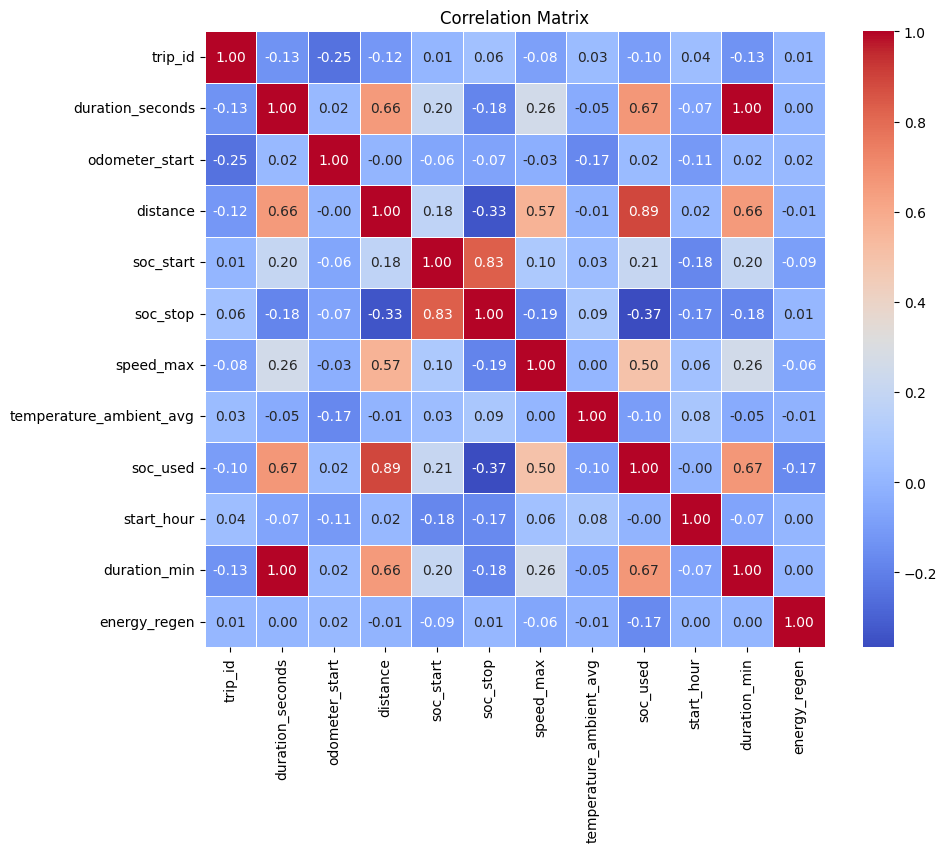

In [22]:
# Compute the correlation matrix for numeric columns
corr_matrix = df.corr(numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# 🔍 Strong Correlations Analysis
**SoC_used** is highly correlated with **duration_seconds**, **distance** and **speed_max**. It suggest that driving behavior plays a significant role in EV performance and energy usage.

# 🎯 Model Choice
We selected tree-based ensemble models (**XGBoost** and **Random Forest**) for training and evaluation. These models are particularly well-suited to our task due to their:

- Robustness to multicollinearity: Both models can handle correlated features without significant degradation in performance.

- Ability to model non-linear relationships: Their architecture naturally captures complex patterns and interactions within the data.

- Interpretability: Feature importance metrics provided by both algorithms offer valuable insights.

After training and comparing both models, we will chose the one that delivers the best balance between accuracy, robustness, and interpretability for our specific use case.

# Import necessary libraries

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  # For splitting the data into training and testing sets
from sklearn.preprocessing import OneHotEncoder  # For encoding categorical variables
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For evaluating model performance
import xgboost as xgb  # Import XGBoost for model training

# 🎯 Feature Selection and Target Definition

In this step, we define the **features** (independent variables) and the **target variable** (dependent variable), is crucial for creating a model that can make accurate predictions by focusing on the most relevant variables:
- **Features** (`X`): These are the columns used to predict the target variable. In our case, we use:
  - **Distance**: The distance traveled during the trip.
  - **Speed max**: The maximum speed achieved during the trip.
  - **Duration in seconds**: The total duration of the trip in seconds.
  - **Fleet type**: The type of fleet (e.g., Commuter, etc.).
  
- **Target** (`y`): The variable to be predicted. In our case, we want to predict the **energy used** during the trip (`soc_used`).

In [24]:
# Define the features (independent variables) and target (dependent variable)
features = ['distance', 'speed_max', 'duration_seconds', 'fleet_type']
target = 'soc_used'

# Create the feature matrix X (input data) and the target vector y (output variable)
X = df[features]
y = df[target]

# 🏷️ One-Hot Encoding for Categorical Variables

In this step, we apply **One-Hot Encoding** to the categorical variable **'fleet_type'**.

In [25]:
# Apply One-Hot Encoding to the categorical column 'fleet_type'
X_encoded = pd.get_dummies(X, columns=['fleet_type'], drop_first=True)

# 🔄 Train-Test Split

In this step, we split the data into two subsets:

- **Training Set (80%)**: This subset is used to train the machine learning model. It helps the model learn the relationships between the features and the target variable.
- **Test Set (20%)**: This subset is used to evaluate the model's performance. It simulates how the model will perform on unseen data.

In [26]:
# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🧠 Training the XGBoost Model

In this step, we define and train an **XGBoost Regressor** model:

- **Objective**: We use **'reg:squarederror'** for regression tasks, which minimizes the squared error.
- **n_estimators (100)**: This parameter sets the number of trees (iterations) to be used in the model. A larger number can improve performance, but at the cost of increased training time.
- **max_depth (4)**: The maximum depth of each decision tree. A smaller value can help prevent overfitting.
- **learning_rate (0.1)**: Controls the contribution of each tree. A lower value means that each tree will have a smaller impact that means it requiring more trees to achieve the same result.

In [27]:
# Create the XGBoost Regressor model with specific hyperparameters
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)

# Train the model on the training data
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

# 📊 Model Evaluation
After training the model, we evaluate its performance on the test set using the following metrics **Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)** and **R² Score (Coefficient of Determination)**.
These metrics:
- Help us to assess how well the model generalizes to unseen data.
- **MAE and RMSE** focus on the magnitude of prediction errors, while **R²** evaluates how well the model explains the variance in the target variable.

In [28]:
# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print(f"MAE : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R² : {r2:.3f}")

MAE : 1.523
RMSE : 4.453
R² : 0.806


The model is doing good:
  - Accurate on average (MAE ~1.5)
  - Some bigger errors exist (RMSE > MAE)
  - Captures most of the underlying pattern ( the model explains around 80.6% of the variance and only about 19.4% of the variability is unexplained)

# 🔍 Feature Importance Visualization
In this step, we visualize the importance of each feature in the model’s predictions:
- **Why ?**
  - Feature importance helps us to identify which variables are driving the model's predictions.
  - It allows us to focus on key features and possibly drop less important ones for model optimization.

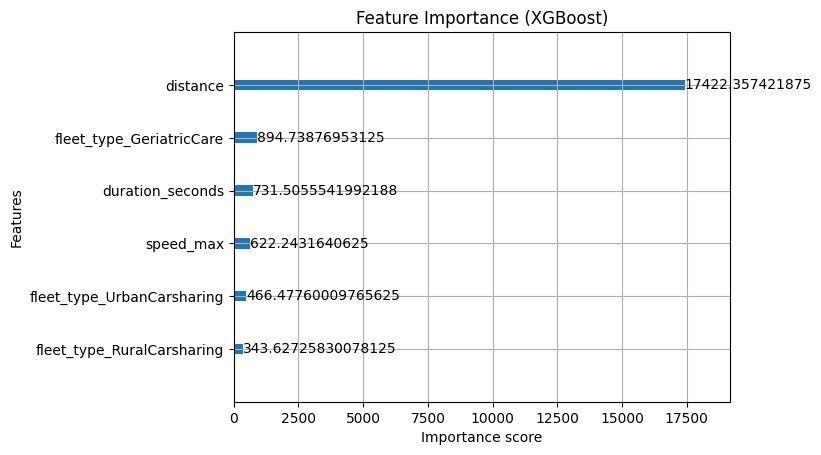

In [29]:
# Plot the feature importance based on the 'gain' metric (how much each feature contributes to reducing the error)
xgb.plot_importance(model_xgb, importance_type='gain', max_num_features=7)

plt.title("Feature Importance (XGBoost)")
plt.show()

The model is heavily relying on the **distance** to make predictions. **fleet_type** and **duration_seconds** also plays a meaningful role.

# 🔍 Hyperparameter Optimization with GridSearchCV

In this step, we perform a search for the best hyperparameters for the XGBoost model using **GridSearchCV**:
### Technique:
- **GridSearchCV**: This method test every possible combination.

In [30]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


# dictionary of lists of parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Define the GridSearchCV with the XGBoost model and hyperparameter grid
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,  
    scoring='neg_mean_absolute_error',  
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    lear...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=4, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error')

# 📈 Best Hyperparameters and Final Model
In this step, we display the best hyperparameters found during the **GridSearchCV** process: we use `grid_search.best_params_` to display the best combination of hyperparameters that produced the best performance.

In [31]:
# Display the best hyperparameters found by GridSearchCV
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best model from the GridSearchCV
best_model_xgb = grid_search.best_estimator_

Best hyperparameters found:
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}


The model learns quickly (0.2), goes deep enough to understand complex patterns (depth 7), and boosts long enough to refine its predictions (300 estimators).

# 📊 Model Evaluation (Best Model)
After optimizing the hyperparameters, it's time to evaluate the performance of the **best model** using common regression metrics.

In [32]:
# Make predictions using the best model
y_pred_best_xgb = best_model_xgb.predict(X_test)

# Calculate performance metrics for the best model
mae_best = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
r2_best = r2_score(y_test, y_pred_best_xgb)

# Display the performance metrics
print(f"MAE (best XGBoost model): {mae_best:.3f}")
print(f"RMSE (best XGBoost model): {rmse_best:.3f}")
print(f"R² (best XGBoost model): {r2_best:.3f}")

MAE (best XGBoost model): 1.313
RMSE (best XGBoost model): 4.153
R² (best XGBoost model): 0.831


📊 Interpretation
- MAE dropped by 13.8 % → the model is now way more precise on average (from 1.523 to 1.313).
- RMSE dropped → the worst predictions are less bad now (from 4.453 to 4.153).
- R² improved → the model explains more of the variability in the target variable (from 0.806 to 0.831).

# 🚗 Model Training and Evaluation: Random Forest
In this part of the code, we aim to use a **Random Forest Regressor** to predict also the **soc_used** based on various features like the **XGBoost**.

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

As we see before our dataset is imbalanced so we add **sample_weight**, we're forcing the model to give proper attention to rare cases, improving overall fairness and potentially predictive performance.

In [34]:
# Compute weights to rebalance under-represented
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions and Evaluate the model
y_pred_rf = model_rf.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


RMSE: 4.276704642547694


The RMSE of **Random Forest (weighted)** is slightly worse than **Tuned XGBoost** but performs better than the **Untuned XGBoost**.

In [35]:
# Hyperparameters to explore
param_dict = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_dict,
    n_iter=20,   # number of iterations
    scoring='neg_root_mean_squared_error',
)

# Fit with sample weights (to handle imbalance)
random_search.fit(X_train, y_train, sample_weight=sample_weights)

# Best model
best_model_rf = random_search.best_estimator_

We're optimizing a Random Forest using randomized hyperparameter tuning while correcting for target imbalance using sample weighting.

In [36]:
# Make predictions using the best Random Forest model
y_pred_best_rf = best_model_rf.predict(X_test)

# Calculate performance metrics for the best Random Forest model
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
r2_best_rf = r2_score(y_test, y_pred_best_rf)

# Display the optimal hyperparameters
print("\n🏆 Best RF Model Parameters:")
print(random_search.best_params_)

# Display the performance metrics
print(f"\nMAE (best Random Forest model): {mae_best_rf:.3f}")
print(f"RMSE (best Random Forest model): {rmse_best_rf:.3f}")
print(f"R² (best Random Forest model): {r2_best_rf:.3f}")


🏆 Best RF Model Parameters:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

MAE (best Random Forest model): 1.317
RMSE (best Random Forest model): 4.279
R² (best Random Forest model): 0.821


**Tunned Random Forest** with hyperparameter and sample weighting improved litle bit the performance over the initial untuned model.

# Comparison of `XGBoost Model` & `Random Forest Model`.

Performance Comparison :
           Model       MAE      RMSE        R²
0        XGBoost  1.313208  4.153112  0.831008
1  Random Forest  1.316984  4.278947  0.820613


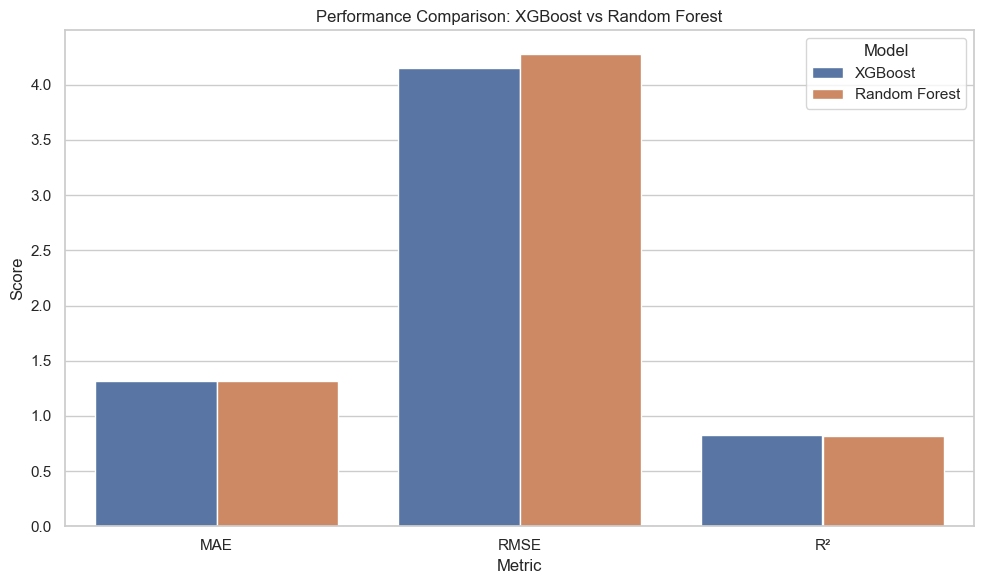

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe to compare performance metrics
comparison_df = pd.DataFrame({
    "Model": ["XGBoost", "Random Forest"],
    "MAE": [mae_best, mae_best_rf],
    "RMSE": [rmse_best, rmse_best_rf],
    "R²": [r2_best, r2_best_rf]
})
print("Performance Comparison :")
print(comparison_df)

# Set the style
sns.set(style="whitegrid")

# Melt the dataframe for easier plotting
comparison_melted = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Create a grouped barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x="Metric", y="Value", hue="Model")
plt.title("Performance Comparison: XGBoost vs Random Forest")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

## 🔍 Interpretation
Both models predict with very close average error.

XGBoost slightly better at penalizing large errors, but both explain ≈ 83 % of variance and it is excellent fit.

The differences are small, so choosing either model is defensible but with preference to XGBoost model.

# 🎯 Conclusion and Future Outlook
This project addressed the problem of predicting the energy consumption of electric vehicle based on some sensor data. The goal was not limited to achieving optimal model performance but centered on designing a reproducible and technically sound data science pipeline. 

## ✅ Conclusion
This project demonstrated that predicting energy consumption per EV trip is feasible and can achieve high accuracy using real-world fleet data.

**Insights:**
- Trip duration and distance are the strongest predictors of energy usage.
- Temperature and fleet_type also play a significant role, indicating the importance of context-aware fleet planning.
- XGBoost achieved the best performance (R² ≈ 0.83), with Random Forest close behind.
## 🔮 Future Work
To improve generalizability and practical impact:
- Include more environmental variables (e.g., elevation, road type, traffic).
- Extend the dataset to cover battery degradation and longer-term usage.
- Test on multiple seasons and extreme weather conditions.

## ⚖️ Ethical Considerations & Limitations

- **Privacy concerns**: The dataset contains detailed driving behavior. Using this data beyond energy optimization (e.g., insurance scoring) may raise ethical questions.
- **Fairness**: Some fleet types are underrepresented, potentially biasing the model toward dominant vehicle types.
- **Generalization**: The dataset reflects specific conditions (region, time). Results can not generalize to other fleets or geographies without retraining.

## 💡 Acknowledgements

We used LLM's ( particularly ChatGPT 4.1 by OpenAI) to:
- Markdown explanations and styling.
- Summarize complex outputs.
- Help structure project sections, translation and correct grammar.

No code or analysis was directly copied. All results were manually reviewed and interpreted by me.

Further appreciation is extended to the developers and contributors of open-source libraries and documentation (such as **Scikit-learn**, **XGBoost** and **Pandas**,.......).